In [1]:
import pandas as pd 
import numpy as np
import json 
import matplotlib.pyplot as plt 
import seaborn as sn
import os
import sys 
sys.path.append('..')
from src.hyperpharmacophore import DistanceHyperpharmacophore
from src.molecule_tools import SDFReader
from src.utils import make_activity_plot
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
target = 'PLK1'

In [3]:
# load results 
df = pd.read_csv('data/crystalStructuresProcessed/{}/predictions.csv'.format(target), index_col=0)
df

,yTrue,yPredInt,yPredLig,alignmentScoreInt,alignmentScoreLig
5ta6,8.823909,5.254828,5.538812,0.418521,0.625859
3thb,8.698970,7.127968,5.543355,0.512139,0.528189
3kb7,8.154902,7.161962,5.398494,0.519697,0.631653
3fc2,9.060481,5.186797,5.556232,0.420479,0.623470
2rku,8.301030,5.254828,5.538812,0.323320,0.625441


In [4]:
predictedPdbs = df[(df.yPredInt != 0)].index
yTrue = df.loc[predictedPdbs].yTrue.values
yPred = df.loc[predictedPdbs].yPredInt.values
rmseInt = mean_squared_error(yTrue, yPred, squared=False)
r2Int = r2_score(yTrue, yPred)
rmseInt, r2Int

(2.845244514000822, -71.38918122811373)

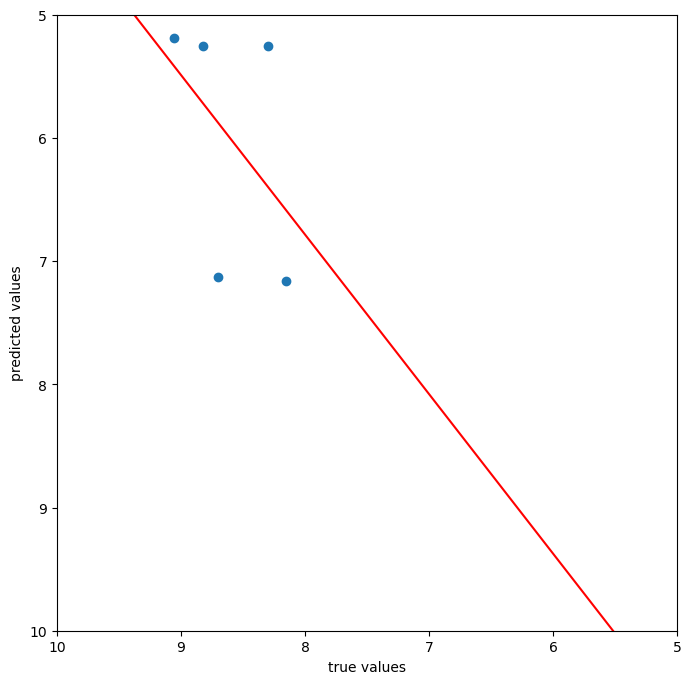

In [5]:
fig, ax = make_activity_plot(yTrue, yPred)
plt.show()
plt.close()

In [6]:
predictedPdbs = df[(df.yPredLig != 0)].index
yTrue = df.loc[predictedPdbs].yTrue.values
yPred = df.loc[predictedPdbs].yPredLig.values
rmseLig = mean_squared_error(yTrue, yPred, squared=False)
r2Lig = r2_score(yTrue, yPred)
rmseLig, r2Lig

(3.106675094353603, -85.30305050704895)

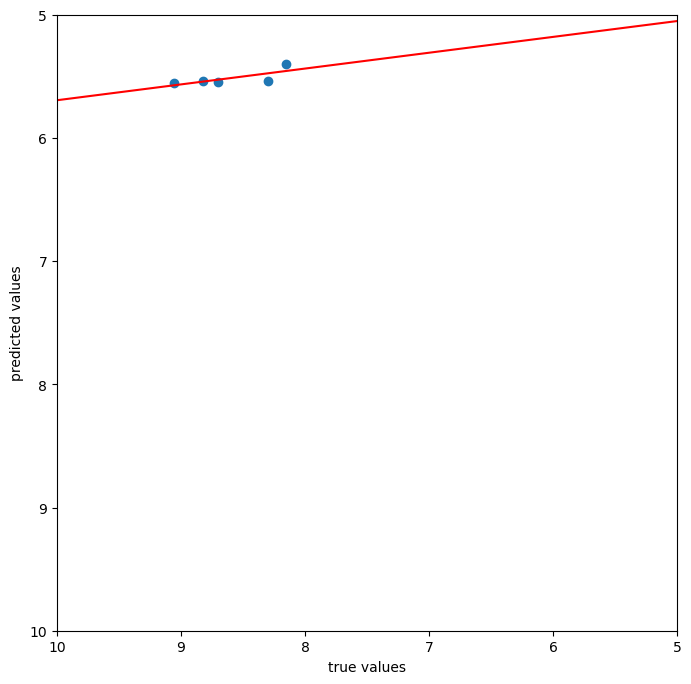

In [7]:
fig, ax = make_activity_plot(yTrue, yPred)
plt.show()
plt.close()

In [8]:
# load qphar model and predict ligand with conformation
model = DistanceHyperpharmacophore()
model.load('data/models/{}/'.format(target))

Loading HP model from data/models/PLK1/


/home/stefan/miniconda3/envs/qphar/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.22.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/stefan/miniconda3/envs/qphar/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.22.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [9]:
ligands = []
for pdbCode in df.index.values: 
    r = SDFReader('data/crystalStructuresProcessed/{}/{}/ligands_conformations.sdf'.format(target, pdbCode))
    ligands.append(r.read())
    
len(ligands)

5

In [10]:
df.shape

(5, 5)

In [11]:
yPred, alignmentScores, mlFeatures, alignedPharmacophores = model.predict(ligands, returnScores=True, returnFeatureData=True, returnAlignedPharmacophores=True)

In [12]:
yPred

array([5.38339046, 7.31629807, 6.74219771, 6.69152963, 8.29387616])

In [13]:
rmse = mean_squared_error(df.yTrue.values, yPred, squared=False)
r2 = r2_score(df.yTrue.values, yPred)
rmse, r2

(2.0667201853077133, -37.194236906096506)

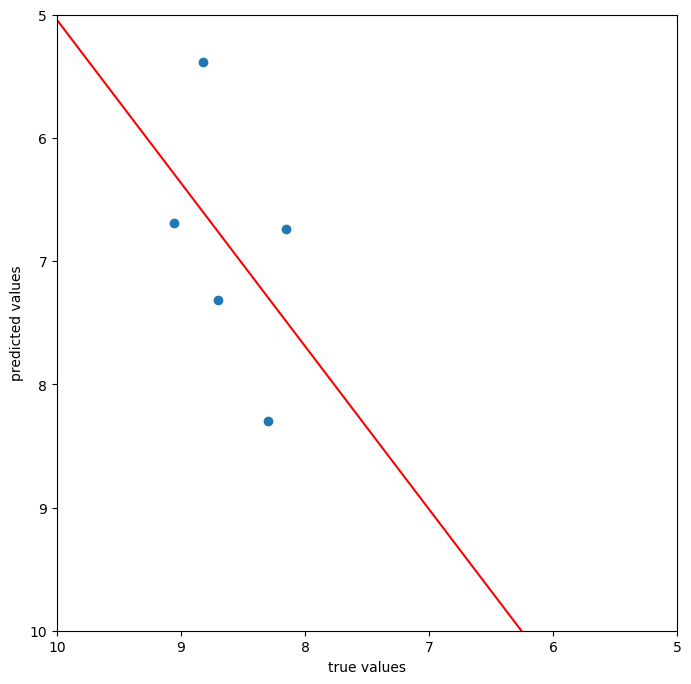

In [14]:
fig, ax = make_activity_plot(df.yTrue.values, yPred)
plt.show()
plt.close()